In [1]:
# Mount the drive 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os
from PIL import Image
import re
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader
import time
import copy


In [ ]:
t = torch.rand(4, 3, 5, 5)
print(t[0])
idx = torch.randperm(t.shape[0])
t = t[idx].view(t.size())

tensor([[[0.4510, 0.7858, 0.7581, 0.5789, 0.2608],
         [0.6513, 0.1778, 0.7864, 0.4604, 0.9025],
         [0.2419, 0.0356, 0.3438, 0.6094, 0.1541],
         [0.2725, 0.1082, 0.7304, 0.1235, 0.8894],
         [0.7216, 0.3261, 0.2283, 0.1418, 0.0377]],

        [[0.8775, 0.8644, 0.3278, 0.1519, 0.5161],
         [0.1557, 0.7499, 0.2886, 0.0913, 0.9066],
         [0.5087, 0.0903, 0.8124, 0.9564, 0.3066],
         [0.9418, 0.7403, 0.4929, 0.6923, 0.5179],
         [0.7683, 0.0467, 0.2839, 0.7775, 0.2069]],

        [[0.9847, 0.8703, 0.3704, 0.7102, 0.3810],
         [0.0529, 0.0863, 0.7995, 0.1799, 0.4311],
         [0.8753, 0.7557, 0.1992, 0.7177, 0.3486],
         [0.2687, 0.3859, 0.9521, 0.5790, 0.8436],
         [0.1450, 0.8021, 0.1442, 0.1311, 0.8962]]])


CUSTOM DATALOADER CLASS


In [21]:
class TrainingDataset_GANM(Dataset):
    def __init__(self,real_img_f,fake_img_f):

        self.real_img_f = real_img_f
        self.fake_img_f = fake_img_f

        for i,x in enumerate(sorted(os.listdir(self.fake_img_f))):
          if i==0:
            image_path_test = self.fake_img_f + '/' + str(x)
            img_one = Image.open(image_path_test)
            img_one_t = transforms.ToTensor()(img_one) #normalized tensor (0,1)
            img_one_t = img_one_t.unsqueeze(0)  # [1,3,128,128]

          if i==1:
            image_path_test = self.fake_img_f + '/' +str(x)
            img_two = Image.open(image_path_test)
            img_two_t = transforms.ToTensor()(img_two) #normalized tensor (0,1)
            img_two_t = img_two_t.unsqueeze(0)
            fake_img_t = torch.cat((img_one_t,img_two_t),0) # [2,3,128,128]

          if i>1:
            image_path_test = self.fake_img_f + '/' + str(x)
            img = Image.open(image_path_test)
            img = transforms.ToTensor()(img) #normalized tensor (0,1)
            img = img.unsqueeze(0)
            fake_img_t = torch.cat((fake_img_t,img),0)


        for i,x in enumerate(sorted(os.listdir(self.real_img_f))):
          if i==0:
            image_path_test = self.real_img_f + '/' + str(x)
            img_one = Image.open(image_path_test)
            img_one_t = transforms.ToTensor()(img_one) #normalized tensor (0,1)
            img_one_t = img_one_t.unsqueeze(0) # [1,3,128,128]

          if i==1:
            image_path_test = self.real_img_f + '/' + str(x)
            img_two = Image.open(image_path_test)
            img_two_t = transforms.ToTensor()(img_two) #normalized tensor (0,1)
            img_two_t = img_two_t.unsqueeze(0)
            real_img_t = torch.cat((img_one_t,img_two_t),0) # [2,3,128,128]

          if i>1:
            image_path_test = self.real_img_f + '/' + str(x)
            img = Image.open(image_path_test)
            img = transforms.ToTensor()(img) #normalized tensor (0,1)
            img = img.unsqueeze(0)
            real_img_t = torch.cat((real_img_t,img),0)

        one_labels = torch.ones((1000,1),dtype=float) # [1000,1]
        zero_labels = torch.zeros((1000,1),dtype=float) # [1000,1]

        self.total_data = torch.cat((real_img_t,fake_img_t),0) # [2000,3,128,128]
        self.total_labels = torch.cat((one_labels,zero_labels),0) # [2000,1]


    def __len__(self):
        return(self.total_labels.shape[0])
    
    def __getitem__(self,idx):
        return self.total_data[idx],self.total_labels[idx]

In [22]:
fake_folder_path = '/content/drive/MyDrive/courses/ml/ganimation_replicate/results/celebA_ganimation_30/fake'
real_folder_path = '/content/drive/MyDrive/courses/ml/ganimation_replicate/results/celebA_ganimation_30/true'

In [50]:
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 25


# Train, Validation and Test Split 
dst = TrainingDataset_GANM(real_folder_path,fake_folder_path)
v_split = 0.5 # percentage of test data for validation 
train_split = 0.8
test_split = 0.2

dst_size = len(dst)
indices = list(range(dst_size))

test_data_split = int(np.floor(test_split * dst_size))

np.random.shuffle(indices)

train_indices, test_temp_indices = indices[test_data_split:], indices[:test_data_split]

val_data_split = int(np.floor(v_split * test_data_split ))
test_indices,val_indices = test_temp_indices[val_data_split:],test_temp_indices[:val_data_split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dst, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dst, batch_size=batch_size,sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(dst, batch_size=batch_size,sampler=test_sampler)




In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np


torch.Size([25, 3, 128, 128])


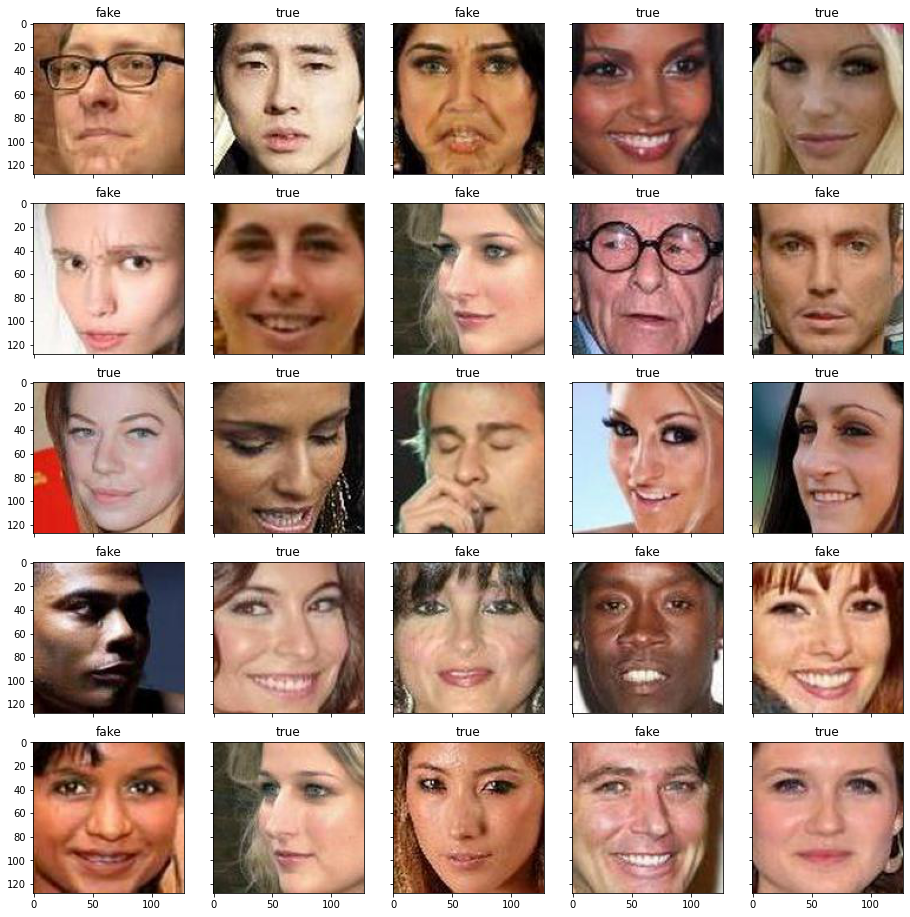

In [52]:
# display Train Images

imgs,lbls = next(iter(train_loader))
print(imgs.shape)


fig = plt.figure(1, (16., 16.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 5),
                 axes_pad=0.4,
                 )

for i,axes in enumerate(grid):
    if int(lbls[i].squeeze().item()) == 0:
      axes.set_title(f"fake", fontdict=None, loc='center', color = "k")
    else:
      axes.set_title(f"true", fontdict=None, loc='center', color = "k")

    
    axes.imshow(imgs[i].permute(1,2,0))

  

plt.show()



torch.Size([25, 3, 128, 128])


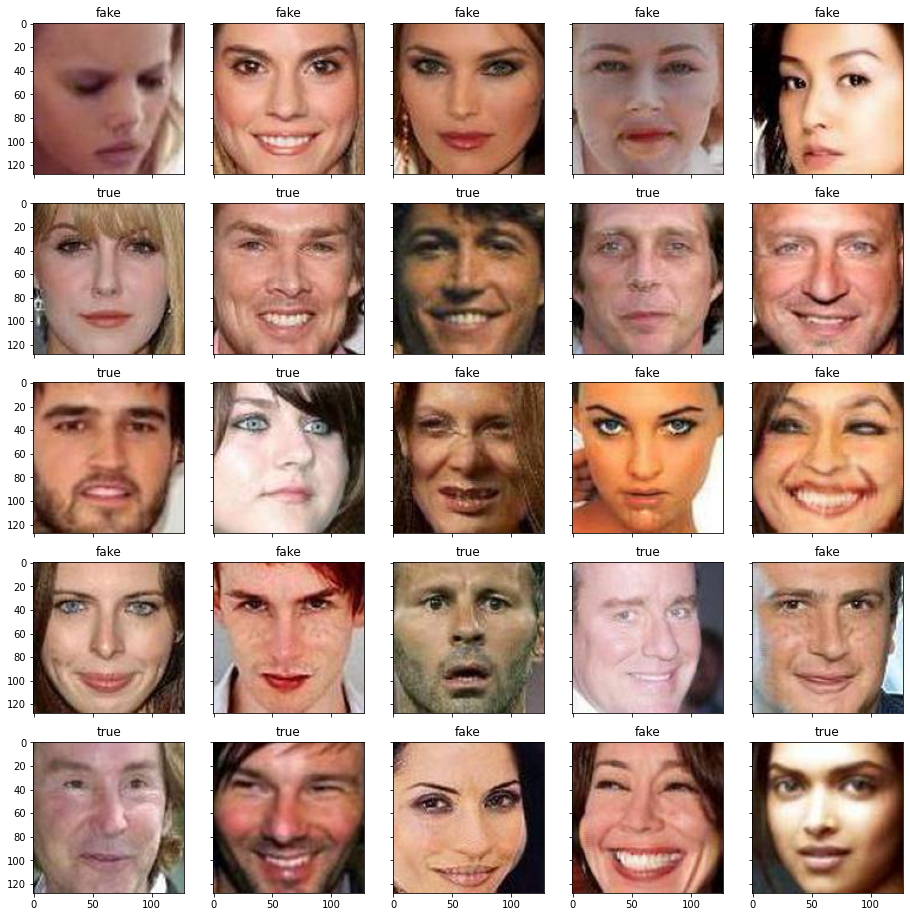

In [53]:
# display validation Images


imgs,lbls = next(iter(validation_loader))
print(imgs.shape)


fig = plt.figure(1, (16., 16.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 5),
                 axes_pad=0.4,
                 )

for i,axes in enumerate(grid):
    if int(lbls[i].squeeze().item()) == 0:
      axes.set_title(f"fake", fontdict=None, loc='center', color = "k")
    else:
      axes.set_title(f"true", fontdict=None, loc='center', color = "k")

    
    axes.imshow(imgs[i].permute(1,2,0))

  

plt.show()

torch.Size([25, 3, 128, 128])


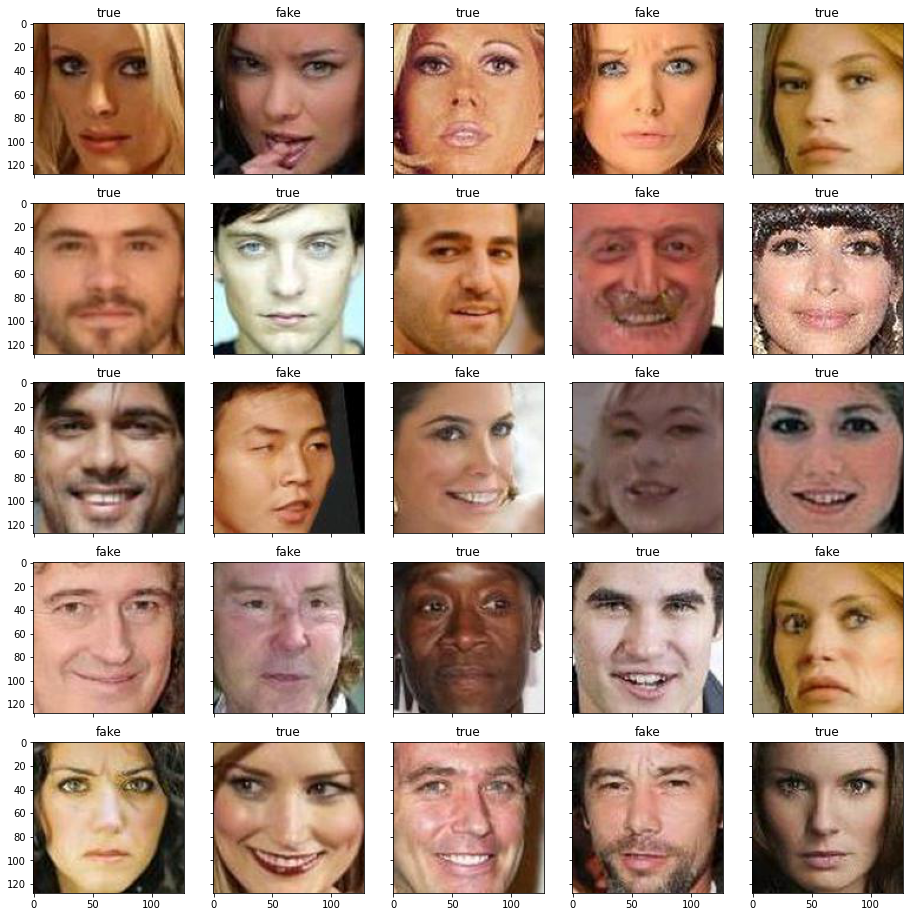

In [54]:
#print test images

imgs,lbls = next(iter(test_loader))
print(imgs.shape)


fig = plt.figure(1, (16., 16.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 5),
                 axes_pad=0.4,
                 )

for i,axes in enumerate(grid):
    if int(lbls[i].squeeze().item()) == 0:
      axes.set_title(f"fake", fontdict=None, loc='center', color = "k")
    else:
      axes.set_title(f"true", fontdict=None, loc='center', color = "k")

    
    axes.imshow(imgs[i].permute(1,2,0))

  

plt.show()

In [7]:
print(len(train_loader))
print(len(test_loader))
print(len(validation_loader))
imgs,lbls = next(iter(train_loader))
imgs.shape

32
4
4


torch.Size([50, 3, 128, 128])

In [55]:


def train_model(model, criterion, optimizer,train_loader,test_loader,validation_loader,device,num_epochs=1):

  model = model.to(device)


  val_loss = []
  val_acc = []

  for epoch in range(num_epochs):

    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    count = 0

    model.train()

    running_loss = 0.0
    running_corrects = 0

  

        # Iterate over data.
    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)


        # print(inputs.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(inputs)
        print(outputs.shape,labels.shape)
        labels = torch.squeeze(labels)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)   #since loss.item() is average, we multiply by batch_size 

        _,pred = torch.max(outputs, dim=1)

        running_corrects += torch.sum(pred==labels).item()

        print(f"Batch loss : {loss.item()} Batch accuracy : {torch.sum(pred==labels).item()/inputs.size(0)}")
      
      

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = (running_corrects)/(len(train_loader.dataset))

    print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
      model.eval()

      for data_t, target_t in (validation_loader):

          data_t = data_t.to(device)
          target_t = target_t.to(device)

          outputs_t = model(data_t)
          target_t = torch.squeeze(target_t)
          target_t = target_t.type(torch.LongTensor)
          target_t = target_t.to(device)
          outputs_t = outputs_t.to(device)
          loss_t = criterion(outputs_t, target_t)


          batch_loss += loss_t.item()
          _,pred_t = torch.max(outputs_t, dim=1)

          # print(pred_t)
          # print(target_t)
          correct_t += torch.sum(pred_t==target_t).item()
          total_t += target_t.size(0)
      val_acc.append(100 * correct_t / total_t)
      val_loss.append(batch_loss/len(validation_loader))
      # network_learned = batch_loss < valid_loss_min
      print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')


    

  return model


In [37]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

## Experiment - 1 : Resnet-18

In [73]:
model_ft = models.resnet50(pretrained=False)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.0001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_rt  = train_model(model_ft, criterion, optimizer,train_loader,test_loader,validation_loader,device,num_epochs=5)


Epoch 0/4
----------
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.6631421446800232 Batch accuracy : 0.6
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.96881502866745 Batch accuracy : 0.44
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.8097496032714844 Batch accuracy : 0.44
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.6826474070549011 Batch accuracy : 0.64
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.6756288409233093 Batch accuracy : 0.6
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.922309398651123 Batch accuracy : 0.56
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 1.1138198375701904 Batch accuracy : 0.2
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.7949377298355103 Batch accuracy : 0.4
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.7016163468360901 Batch accuracy : 0.56
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.6702429056167603 Batch accuracy : 0.6
torch.Size([25, 2]) torch.Size([25, 1])
Batch l

## Experiment - 2: Resnet 50 

In [74]:
model_ft = models.resnet50(pretrained=False)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.0001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_rt  = train_model(model_ft, criterion, optimizer,train_loader,test_loader,validation_loader,device,num_epochs=5)

Epoch 0/4
----------
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.8254377841949463 Batch accuracy : 0.52
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.7153694033622742 Batch accuracy : 0.48
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.6825256943702698 Batch accuracy : 0.44
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.8934412598609924 Batch accuracy : 0.48
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.6928324103355408 Batch accuracy : 0.52
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.7733615636825562 Batch accuracy : 0.52
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.7492522597312927 Batch accuracy : 0.52
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.8297916650772095 Batch accuracy : 0.44
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.7834179401397705 Batch accuracy : 0.4
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.7679311633110046 Batch accuracy : 0.44
torch.Size([25, 2]) torch.Size([25, 1])


## Experiment - 3: VGG16

In [76]:
model_ft = models.vgg16(pretrained=False)
# num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(512, 2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.0001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_rt  = train_model(model_ft, criterion, optimizer,train_loader,test_loader,validation_loader,device,num_epochs=5)

Epoch 0/4
----------
torch.Size([25, 1000]) torch.Size([25, 1])
Batch loss : 6.922738075256348 Batch accuracy : 0.0
torch.Size([25, 1000]) torch.Size([25, 1])
Batch loss : 6.205080986022949 Batch accuracy : 0.68
torch.Size([25, 1000]) torch.Size([25, 1])
Batch loss : 3.4108622074127197 Batch accuracy : 0.48
torch.Size([25, 1000]) torch.Size([25, 1])
Batch loss : 2.5336503982543945 Batch accuracy : 0.64
torch.Size([25, 1000]) torch.Size([25, 1])
Batch loss : 1.0860340595245361 Batch accuracy : 0.6
torch.Size([25, 1000]) torch.Size([25, 1])
Batch loss : 3.0506110191345215 Batch accuracy : 0.56
torch.Size([25, 1000]) torch.Size([25, 1])
Batch loss : 1.9616481065750122 Batch accuracy : 0.64
torch.Size([25, 1000]) torch.Size([25, 1])
Batch loss : 1.2311182022094727 Batch accuracy : 0.44
torch.Size([25, 1000]) torch.Size([25, 1])
Batch loss : 0.8120601177215576 Batch accuracy : 0.52
torch.Size([25, 1000]) torch.Size([25, 1])
Batch loss : 1.3148856163024902 Batch accuracy : 0.48
torch.Size([2

## Experiment - 4: Resnet101



In [83]:
model_ft = models.resnet101(pretrained=False)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.0001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_rt  = train_model(model_ft, criterion, optimizer,train_loader,test_loader,validation_loader,device,num_epochs=5)

Epoch 0/4
----------
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.8573775291442871 Batch accuracy : 0.56
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.7336281538009644 Batch accuracy : 0.68
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.7362878322601318 Batch accuracy : 0.56
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.7842352390289307 Batch accuracy : 0.44
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.701992392539978 Batch accuracy : 0.56
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.6464146971702576 Batch accuracy : 0.64
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.8303598761558533 Batch accuracy : 0.48
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.7729923725128174 Batch accuracy : 0.48
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.8405358791351318 Batch accuracy : 0.48
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.6967223286628723 Batch accuracy : 0.56
torch.Size([25, 2]) torch.Size([25, 1])


## Pretrained Resnet-50 on Imagenet  

In [84]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.0001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_rt  = train_model(model_ft, criterion, optimizer,train_loader,test_loader,validation_loader,device,num_epochs=5)

Epoch 0/4
----------
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.7493242025375366 Batch accuracy : 0.4
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.6916183233261108 Batch accuracy : 0.56
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.7035386562347412 Batch accuracy : 0.52
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.7332174181938171 Batch accuracy : 0.64
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.7747250199317932 Batch accuracy : 0.4
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.7474133372306824 Batch accuracy : 0.44
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.7033917903900146 Batch accuracy : 0.56
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.7578068375587463 Batch accuracy : 0.44
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.7867695689201355 Batch accuracy : 0.44
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.7330334186553955 Batch accuracy : 0.56
torch.Size([25, 2]) torch.Size([25, 1])
B

## Tuning Resnet-50 Pretrained model for improving accuracy

In [86]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=0.0001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_rt  = train_model(model_ft, criterion, optimizer,train_loader,test_loader,validation_loader,device,num_epochs=50)

Streaming output truncated to the last 5000 lines.
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.022892193868756294 Batch accuracy : 1.0
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.042387887835502625 Batch accuracy : 1.0
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.06748706847429276 Batch accuracy : 1.0
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.040709517896175385 Batch accuracy : 1.0
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.010105273686349392 Batch accuracy : 1.0
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.08019433170557022 Batch accuracy : 0.92
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.015480931848287582 Batch accuracy : 1.0
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.006049490068107843 Batch accuracy : 1.0
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.42104288935661316 Batch accuracy : 0.96
torch.Size([25, 2]) torch.Size([25, 1])
Batch loss : 0.018357018008828163 Batch accuracy : 1.0


## Test model 

In [94]:
correct_t = 0
total_t = 0

data_fb = []   #first batch store results

with torch.no_grad():
  model_rt.eval()

  for batch_idx,(data_t, target_t) in enumerate((test_loader)):

      data_t = data_t.to(device)
      target_t = target_t.to(device)

      outputs_t = model_rt(data_t)
      target_t = torch.squeeze(target_t)
      target_t = target_t.type(torch.LongTensor)
      target_t = target_t.to(device)
      outputs_t = outputs_t.to(device)
      loss_t = criterion(outputs_t, target_t)




      # batch_loss += loss_t.item()
      _,pred_t = torch.max(outputs_t, dim=1)
      if batch_idx == 0:
        data_fb.extend([data_t,target_t,pred_t])

      correct_t += torch.sum(pred_t==target_t).item()
      total_t += target_t.size(0)

  # network_learned = batch_loss < valid_loss_min
  print(f' Test acc: {(100 * correct_t / total_t):.4f}\n')

 Test acc: 72.0000



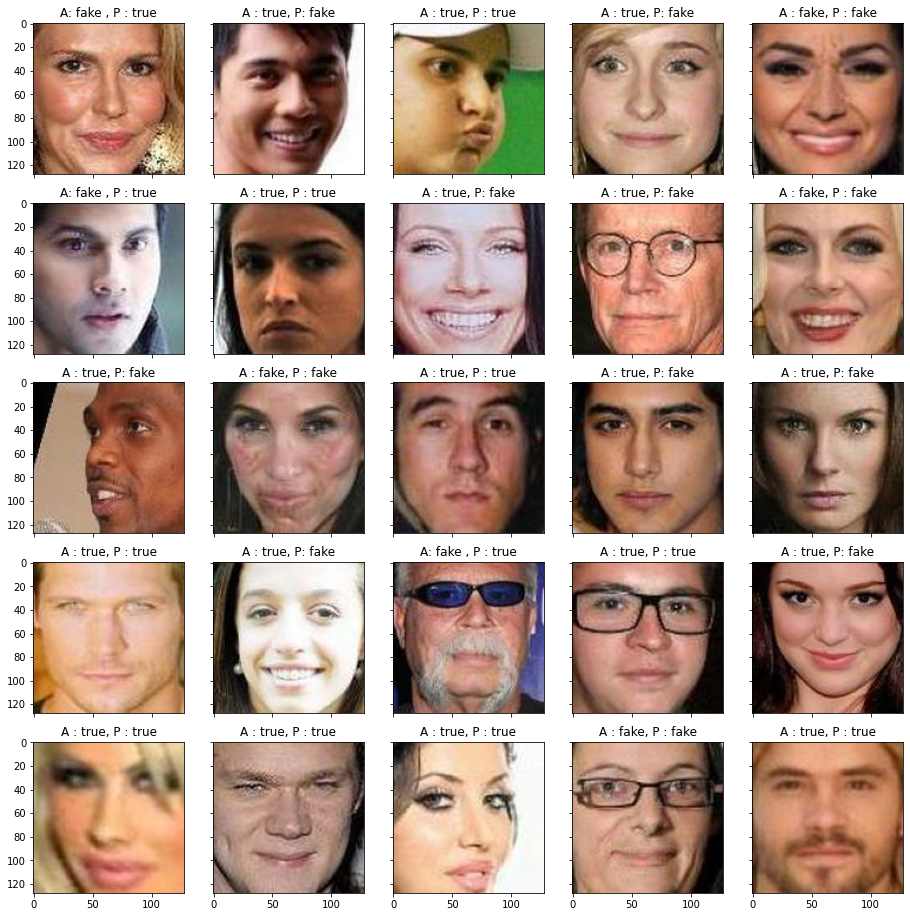

In [98]:
# Check Predictions Visually 

imgs = data_fb[0]
target_lbls = data_fb[1]
pred_lbls = data_fb[2]


fig = plt.figure(1, (16., 16.))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 5),
                 axes_pad=0.4,
                 )

for i,axes in enumerate(grid):
    if int(target_lbls[i].squeeze().item()) == 0 and int(pred_lbls[i].squeeze().item()) == 0:
      axes.set_title(f"A : fake, P : fake", fontdict=None, loc='center', color = "k")
    if int(target_lbls[i].squeeze().item()) == 0 and int(pred_lbls[i].squeeze().item()) == 1:
      axes.set_title(f"A: fake , P : true", fontdict=None, loc='center', color = "k")
    if int(target_lbls[i].squeeze().item()) == 1 and int(pred_lbls[i].squeeze().item()) == 0:
      axes.set_title(f"A : true, P: fake", fontdict=None, loc='center', color = "k")
    if int(target_lbls[i].squeeze().item()) == 1 and int(pred_lbls[i].squeeze().item()) == 1:
      axes.set_title(f"A : true, P : true", fontdict=None, loc='center', color = "k")



    
    axes.imshow(imgs[i].cpu().permute(1,2,0))

  

plt.show()

